In [1]:
"""
Imports
"""
import json, time
import numpy as np
import pandas as pd

import sys
rootPath = '../../../'
sys.path.insert(0, rootPath+'Architecture/')
from groundTruth import GroundTruth
from statistics import Statistics
from dataManagement import Scaler

from ods import Sample, ODS
from multiprocessing import Process, Queue
np.seterr(invalid='ignore')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
radius_factor_type = 'dynamic'
maxProcesses = 4

In [3]:
def get_features_node(node, rootPath):
    features_node = json.loads(open(rootPath+'features_node.json').read())
    features_to_use = features_node[node]['DataPlane']+features_node[node]['ControlPlane']
    features_to_use = features_to_use+['time']
    len(features_to_use)
    return features_to_use

def grid_opt(lamb, beta, tp, queue):
    print('Starting process lamb: {} | beta: {} | tp: {}'.format(lamb, beta, tp))

    totalResults = []

    for dataset in ['BGP_testbed_2', 'BGP_testbed_3']:
        config = json.loads(open(rootPath+'configuration.json').read())['datasets'][dataset]    
        for node in config['nodes']: 
            features_node = get_features_node(node, rootPath)
            nodeResults = []

            st = Statistics(dataset, rootPath)

            df = pd.read_csv(rootPath + config['directory']+node+config['filename'],
                             low_memory=False, dtype='float64')\
                    .dropna()
            df = df[features_node]

            times = df['time']//1e9
            times = times.astype('int')
            df.drop(['time'], axis=1, inplace=True)    

            scaler = Scaler()
            dfNormalized = scaler.normalize(df)    
        
            sampleSkip = 30
            
            bufferDF = dfNormalized[0:sampleSkip]
            testDF = dfNormalized[sampleSkip:]
            
            ods = ODS(lamb = lamb,\
                        epsilon = radius_factor_type,\
                        beta = beta,\
                        mu = 'auto',\
                        startingBuffer = bufferDF.values,
                        tp = 'auto')
            ods.runInitialization()

            outputCurrentNode = []
            for sampleNumber in range(len(testDF)):
                sample = testDF.iloc[sampleNumber]
                result = ods.runOnNewSample(Sample(sample.values, times.iloc[sampleNumber]))[0]
                outputCurrentNode.append(result)

            df['result'] = [False] * sampleSkip + outputCurrentNode

            for KT in range(1, 5):

                st.getScores(times, df['result'], KT)
                nodeResults.extend([st.gt.Precision, st.gt.Recall])

            totalResults.append(nodeResults)    

    columns = []
    for KT in range(1,5):
        columns.extend(['Precision_K_'+str(KT), 'Recall_K_'+str(KT)])

    results = pd.DataFrame(totalResults, index=config['nodes']+config['nodes'], columns=columns) 
    
    queue.put([(lamb, beta, tp), results])
    return 

In [4]:
%%time

q = Queue()
jobs = []

"""
Initialize Processes
"""
lambs = np.arange(0.01, 0.45, 0.03)
betas = np.arange(0.1, 1, 0.1)

tps = ['auto']

parametersToTest = []
for lamb in lambs:
    for beta in betas:
        for tp in tps:
            parametersToTest.append((round(lamb,5), round(beta,5), tp))

totalProcesses = len(lambs)*len(betas)*len(tps)


out_results = {}
currentProcess = 0
activeProcesses = 0

while currentProcess < totalProcesses:
    
    if (activeProcesses < maxProcesses) and len(parametersToTest)>0:
        lamb, beta, tp = parametersToTest.pop()
        p = Process(target=grid_opt, args=(lamb, beta, tp, q),)
        p.start()
        activeProcesses+=1
    else:
        res = q.get()
        if res is None:
            time.sleep(0.00000001)
            continue
        else:
            out_results[res[0]] = res[1]
            currentProcess+=1
            activeProcesses-=1
            
    time.sleep(0.00000001)

Starting process lamb: 0.43 | beta: 0.9 | tp: auto
Starting process lamb: 0.43 | beta: 0.8 | tp: auto
Starting process lamb: 0.43 | beta: 0.7 | tp: autoStarting process lamb: 0.43 | beta: 0.6 | tp: auto

Starting process lamb: 0.43 | beta: 0.5 | tp: auto
Starting process lamb: 0.43 | beta: 0.4 | tp: auto
Starting process lamb: 0.43 | beta: 0.3 | tp: auto
Starting process lamb: 0.43 | beta: 0.2 | tp: auto
Starting process lamb: 0.43 | beta: 0.1 | tp: auto
Starting process lamb: 0.4 | beta: 0.9 | tp: auto
Starting process lamb: 0.4 | beta: 0.8 | tp: auto
Starting process lamb: 0.4 | beta: 0.7 | tp: auto
Starting process lamb: 0.4 | beta: 0.6 | tp: auto
Starting process lamb: 0.4 | beta: 0.5 | tp: auto
Starting process lamb: 0.4 | beta: 0.4 | tp: auto
Starting process lamb: 0.4 | beta: 0.3 | tp: auto
Starting process lamb: 0.4 | beta: 0.2 | tp: auto
Starting process lamb: 0.4 | beta: 0.1 | tp: auto
Starting process lamb: 0.37 | beta: 0.9 | tp: auto
Starting process lamb: 0.37 | beta: 0.8 

In [5]:
def getF1(precision, recall, beta=0.5):
    return (1+beta*beta)*precision*recall/((beta*beta*precision)+recall)

precision = []
recall = []
f1 = []
index = []

for x in out_results:
    result = out_results[x].mean()
    precision.append(result['Precision_K_1'])
    recall.append(result['Recall_K_1'])
    f1.append(getF1(result['Precision_K_1'],result['Recall_K_1']))
    index.append(x)

In [6]:
results_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(index))
results_df['precision'] = precision
results_df['recall'] = recall
results_df['f1'] = f1

f1_scores_heatmap = pd.DataFrame()
precision_scores_heatmap = pd.DataFrame()
recall_scores_heatmap = pd.DataFrame()

for lamb in lambs:
    lamb = round(lamb, 5)
    results_current_lamb = results_df['f1'][lamb,:,'auto'].sort_index()
    f1_scores_heatmap[str(lamb)] = results_current_lamb
    precision_scores_heatmap[str(lamb)] = results_df['precision'][lamb,:,'auto'].sort_index()
    recall_scores_heatmap[str(lamb)] = results_df['recall'][lamb,:,'auto'].sort_index()

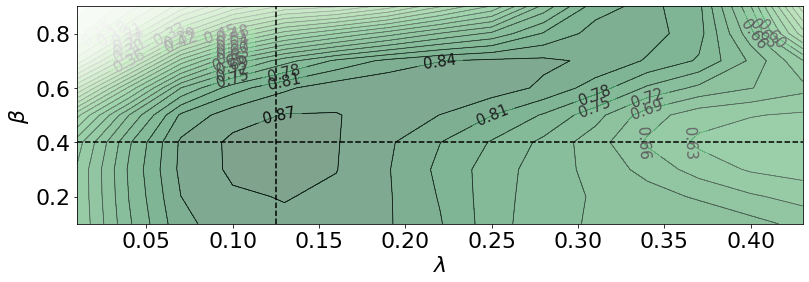

In [7]:
from scipy import misc
from scipy.ndimage import gaussian_filter

X = lambs
Y = betas
result = gaussian_filter(f1_scores_heatmap, sigma=1)

fontsizeLabel = 22
fontsizeTicks = 22
fontsizeCurves = 15

levels = 26

fig, ax = plt.subplots(figsize=(13,4))
CS = ax.contour(X, Y, result, levels = levels, origin='lower', cmap='Greys', linewidths=0.8)
ax.contourf(X, Y, result, levels = levels, origin='lower', cmap='Greens', alpha=0.5)
ax.clabel(CS, inline=1, fmt='%1.2f', fontsize=fontsizeCurves)
ax.tick_params(axis='both', which='major', labelsize=fontsizeLabel)
ax.tick_params(axis='both', which='minor', labelsize=fontsizeLabel)
ax.set_ylabel(r'$\beta$', fontsize=fontsizeLabel)
ax.set_xlabel(r'$\lambda$', fontsize=fontsizeLabel)
ax.axhline(0.4, c='k', linestyle='--')
ax.axvline(0.125, c='k', linestyle='--')

plt.savefig('Figures/lambda_vs_beta.pdf', bbox_inches='tight', pad_inches=0)